In [255]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [2]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [3]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [134]:
latent_df = pd.read_csv("latent_representation.csv")
latent_df.drop(columns=["Unnamed: 0"], inplace=True)

In [135]:
latent_array = latent_df.to_numpy()

In [136]:
categories = df['bulk_labels'].unique()

#one-hot encoding
y = np.zeros((len(df), len(categories)))

for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y, latent_array = X[permutation], y[permutation], latent_array[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]
latent_train, latent_test = latent_array[:int(len(X)*0.8)], latent_array[int(len(y)*0.8):]

In [222]:
X_with_latent = pd.concat([pd.DataFrame(X_train), pd.DataFrame(latent_train)], axis=1)
X_with_latent_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(latent_test)], axis=1)
X_with_latent

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,-0.326,-0.191,-0.728,0.375,-0.174,-0.531,1.710,-0.486,-0.459,-0.525,...,1.665027,-7.263534,-2.578431,-1.124364,-4.475476,-3.233130,-6.334409,-5.886111,2.091651,-2.325582
1,-0.326,-0.191,-0.728,-1.200,-0.174,0.691,-0.451,-0.486,-0.459,-0.525,...,-1.986991,-1.273436,-0.447838,1.497603,-2.042077,-0.095712,-1.617816,-2.488383,0.301332,-2.589818
2,-0.326,-0.191,0.320,-0.613,-0.174,-0.531,-0.451,-0.486,-0.459,0.691,...,-2.711268,1.344612,0.939687,-2.966659,-0.068419,3.984865,-1.401290,-5.229717,1.882876,-0.909079
3,-0.326,1.640,0.110,-0.731,-0.174,-0.531,0.836,-0.486,-0.459,-0.525,...,-8.870703,-3.825246,2.169926,-1.906959,-9.000407,3.234879,-6.281198,-7.867739,6.538891,-3.121614
4,-0.326,-0.191,0.576,0.260,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.851332,-7.197829,-5.831672,2.677095,-8.351477,-2.586161,-5.080958,-4.776226,1.342880,-0.009338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,-0.326,-0.191,-0.728,0.276,-0.174,-0.531,-0.451,-0.486,-0.459,2.534,...,-1.983275,1.430248,0.368182,-3.731228,-1.280631,6.264500,-0.761367,-5.566248,2.667042,-1.825750
556,-0.326,-0.191,-0.728,-0.067,-0.174,0.426,-0.451,-0.486,-0.459,0.649,...,-1.448982,2.089238,0.958634,-2.867045,0.404182,4.630292,0.490274,-4.174965,0.796744,0.413798
557,3.762,-0.191,0.658,-0.424,-0.174,-0.531,-0.451,1.182,4.118,-0.525,...,-1.783135,-5.342024,-2.884557,-2.687669,-0.812161,5.585697,-7.107585,-5.796074,-2.414414,0.659805
558,1.006,-0.191,1.981,1.075,-0.174,0.751,-0.451,1.144,1.032,-0.525,...,-2.541760,-2.358821,-0.175796,-0.511089,-2.147151,2.050919,-3.354689,-3.054996,-0.533675,-1.256599


In [223]:
X_with_latent.columns = [i for i in range(len(X_with_latent.columns))]
X_with_latent_test.columns = [i for i in range(len(X_with_latent_test.columns))]

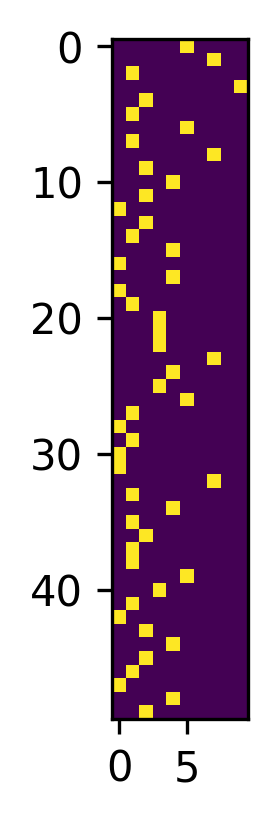

In [5]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [7]:
def plot_class_distributions(y1, y2):
    plt.figure(figsize=(8,8))
    a1 =list(np.bincount(y1) + np.bincount(y2))
    a2 = ["class "+str(i) for i in range(1, len(a1)+1)]
    plt.pie(a1, labels=a2)
    plt.show()

In [150]:
y_train_idx = np.argmax(y_train, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
y_full = np.argmax(y, axis=1)

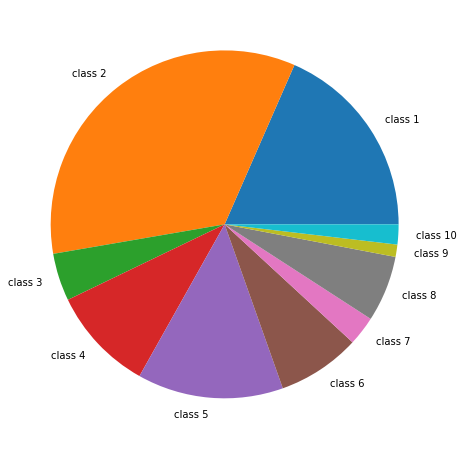

In [9]:
plot_class_distributions(y_train_idx, y_test_idx)

#### Random Forest

In [102]:
param_random_forest = {
    "n_estimators": [1000, 1300, 1500],
    "criterion": ["gini"],
    "max_depth": list(range(10, 23, 2)),
    "class_weight": ["balanced_subsample"],
}


param_logistic_reg = [
    # Valid for solver='lbfgs', 'newton-cg', 'sag'
    {'solver': ['lbfgs', 'newton-cg', 'sag'], 'penalty': ['l2'], 'C': [0.1, 1, 10]},

    # Valid for solver='liblinear'
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]},

    # Valid for solver='saga' and elasticnet
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': [0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7]},
    
    # Also allow saga with l1 or l2
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}
]

In [70]:
grid_random_forest = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_random_forest,
    n_jobs=-1,
    cv=5,
    scoring='f1_weighted'
)

In [57]:
grid_random_forest.fit(X=X_train, y=y_train_idx)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['gini'],
                         'max_depth': [10, 12, 14, 16, 18, 20, 22],
                         'n_estimators': [200, 1500, 2500, 3500]},
             scoring='f1_weighted')

In [58]:
RF_top_10 = pd.DataFrame(grid_random_forest.cv_results_).sort_values("rank_test_score").head(5)

In [59]:
RF_top_10.iloc[1, ]["params"]

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 14,
 'n_estimators': 1500}

In [60]:
RF_top_10

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,19.844007,0.113030,0.137375,0.006513,balanced_subsample,gini,10,1500,"{'class_weight': 'balanced_subsample', 'criter...",0.784818,0.750228,0.821633,0.769815,0.825162,0.790331,0.029163,1
9,22.836142,0.178470,0.149393,0.012470,balanced_subsample,gini,14,1500,"{'class_weight': 'balanced_subsample', 'criter...",0.784632,0.758877,0.811947,0.756261,0.824414,0.787226,0.027435,2
3,51.282850,0.662304,0.349567,0.052175,balanced_subsample,gini,10,3500,"{'class_weight': 'balanced_subsample', 'criter...",0.784632,0.750228,0.822563,0.770381,0.807207,0.787002,0.025718,3
2,35.618985,1.425610,0.241983,0.013535,balanced_subsample,gini,10,2500,"{'class_weight': 'balanced_subsample', 'criter...",0.784632,0.750228,0.812992,0.770381,0.815810,0.786809,0.025058,4
10,38.830538,0.326905,0.256630,0.014985,balanced_subsample,gini,14,2500,"{'class_weight': 'balanced_subsample', 'criter...",0.784818,0.758877,0.802377,0.756261,0.824247,0.785316,0.025885,5


In [61]:
grid_random_forest.best_score_

0.7903311956260284

#### Logistic Regression

In [194]:
lg_results_Array = [[], [], []]

In [193]:
lr = LogisticRegression()
grid_search_LR = GridSearchCV(lr, 
                              param_grid=param_logistic_reg,
                             n_jobs=-1,
                             cv=5,
                             scoring="f1_weighted")
grid_search_LR.fit(X=X_train, y=y_train_idx)

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg', 'sag']},
                         {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7],
                          'penalty': ['elasticnet'], 'solver': ['saga']},
                         {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                          'solver': ['saga']}],
             scoring='f1_weighted')

In [156]:
grid_search_LR.best_score_

0.8361631768066161

In [195]:
lg_results_Array[0].append(grid_search_LR.best_score_)
lg_results_Array[1].append("1st try")
lg_results_Array[2].append(grid_search_LR.best_params_)

In [196]:
LR_top_10 = pd.DataFrame(grid_search_LR.cv_results_).sort_values("rank_test_score").head(5)

In [197]:
LR_top_10.iloc[1, ]["params"]

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [198]:
LR_top_10

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.257786,0.013246,0.003025,0.000893,1,l2,lbfgs,NaN,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.819333,0.771006,0.815303,0.814734,0.814016,0.806878,0.018031,1
4,0.338618,0.050093,0.002882,0.000465,1,l2,newton-cg,NaN,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.819333,0.771006,0.815303,0.814734,0.814016,0.806878,0.018031,1
0,0.320083,0.013099,0.003925,0.000272,0.1,l2,lbfgs,NaN,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.819333,0.771006,0.814993,0.814429,0.814016,0.806755,0.017976,3
1,0.385674,0.048515,0.003117,0.000551,0.1,l2,newton-cg,NaN,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.819333,0.771006,0.814993,0.814429,0.814016,0.806755,0.017976,3
7,0.312835,0.016651,0.002400,0.000490,10,l2,newton-cg,NaN,"{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}",0.807515,0.754049,0.813998,0.814734,0.814016,0.800862,0.023553,5


In [84]:
# we can see that nearly all of the top ones are C=10, so lets do it around C=1 this time
# param_solver is either newton-cg or lbfgs for the top 5 
# and because of its dependence on solver, penalty is l2 automatically. 
# So, lets makes our boundaries smaller.

In [200]:
param_logistic_reg_2 = [
    {'solver': ['lbfgs', 'newton-cg'], 'penalty': ['l2'], 'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
                                                                1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]},
]

In [201]:
grid_search_LR_2 = GridSearchCV(lr, 
                              param_grid=param_logistic_reg_2,
                             n_jobs=-1,
                             cv=5,
                             scoring="f1_weighted")
grid_search_LR_2.fit(X=X_train, y=y_train_idx)

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
                                1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9],
                          'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg']}],
             scoring='f1_weighted')

In [202]:
grid_search_LR_2.best_score_

0.8087656174884638

In [203]:
lg_results_Array[0].append(grid_search_LR_2.best_score_)
lg_results_Array[1].append("Solver is newton-cg/lbfgs and C~1")
lg_results_Array[2].append(grid_search_LR_2.best_params_)

In [207]:
LR_top_10 = pd.DataFrame(grid_search_LR_2.cv_results_).sort_values("rank_test_score").head(5)

In [208]:
LR_top_10

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.332351,0.007447,0.003630,0.000420,0.2,l2,lbfgs,"{'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}",0.819333,0.771006,0.824740,0.814734,0.814016,0.808766,0.019266,1
3,0.477543,0.027260,0.003718,0.000754,0.2,l2,newton-cg,"{'C': 0.2, 'penalty': 'l2', 'solver': 'newton-...",0.819333,0.771006,0.824740,0.814734,0.814016,0.808766,0.019266,1
18,0.333431,0.002082,0.004837,0.000781,1,l2,lbfgs,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.819333,0.771006,0.815303,0.814734,0.814016,0.806878,0.018031,3
28,0.322833,0.004477,0.003511,0.000900,1.5,l2,lbfgs,"{'C': 1.5, 'penalty': 'l2', 'solver': 'lbfgs'}",0.819333,0.771006,0.815303,0.814734,0.814016,0.806878,0.018031,3
27,0.483834,0.026971,0.003600,0.000492,1.4,l2,newton-cg,"{'C': 1.4, 'penalty': 'l2', 'solver': 'newton-...",0.819333,0.771006,0.815303,0.814734,0.814016,0.806878,0.018031,3


In [209]:
param_logistic_reg_3 = [
    {'solver': ['lbfgs', 'newton-cg'], 'penalty': ['l2'], 'C': [0.15, 0.17, 0.2, 0.21, 0.22, 0.23, 0.25]},
]

In [210]:
grid_search_LR_3 = GridSearchCV(lr, 
                              param_grid=param_logistic_reg_3,
                             n_jobs=-1,
                             cv=5,
                             scoring="f1_weighted")
grid_search_LR_3.fit(X=X, y=y_full)

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.15, 0.17, 0.2, 0.21, 0.22, 0.23, 0.25],
                          'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg']}],
             scoring='f1_weighted')

In [211]:
grid_search_LR_3.best_score_

0.8351628250337644

In [212]:
lg_results_Array[0].append(grid_search_LR_3.best_score_)
lg_results_Array[1].append("C~5")
lg_results_Array[2].append(grid_search_LR_3.best_params_)

In [213]:
LR_top_10 = pd.DataFrame(grid_search_LR_3.cv_results_).sort_values("rank_test_score").head(5)

In [214]:
LR_top_10

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.202019,0.006454,0.002417,0.000475,0.2,l2,lbfgs,"{'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}",0.800023,0.862712,0.817533,0.847347,0.8482,0.835163,0.022904,1
5,0.282313,0.034447,0.001815,0.000408,0.2,l2,newton-cg,"{'C': 0.2, 'penalty': 'l2', 'solver': 'newton-...",0.800023,0.862712,0.817533,0.847347,0.8482,0.835163,0.022904,1
6,0.218465,0.005208,0.002109,0.000817,0.21,l2,lbfgs,"{'C': 0.21, 'penalty': 'l2', 'solver': 'lbfgs'}",0.800023,0.862712,0.817533,0.847347,0.8482,0.835163,0.022904,1
7,0.320080,0.022133,0.002153,0.000267,0.21,l2,newton-cg,"{'C': 0.21, 'penalty': 'l2', 'solver': 'newton...",0.800023,0.862712,0.817533,0.847347,0.8482,0.835163,0.022904,1
8,0.243669,0.004653,0.002693,0.001060,0.22,l2,lbfgs,"{'C': 0.22, 'penalty': 'l2', 'solver': 'lbfgs'}",0.800023,0.862712,0.817533,0.847347,0.8482,0.835163,0.022904,1


In [215]:
# Now lets add latent space representation as additional features and see if it changes the result

In [216]:
grid_search_LR_3.best_params_

{'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}

In [225]:
le = LogisticRegression(C=0.2, penalty="l2", solver="lbfgs")
le.fit(X_train, y_train_idx)

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.2)

In [226]:
le.score(X_test, y_test_idx)

0.8642857142857143

In [227]:
lg_results_Array[0].append(le.score(X_test, y_test_idx))
lg_results_Array[1].append("Best GridSearch Params")
lg_results_Array[2].append(grid_search_LR_3.best_params_)

In [228]:
lg_results_Array

[[0.806878219172494,
  0.8087656174884638,
  0.8351628250337644,
  0.8642857142857143],
 ['1st try',
  'Solver is newton-cg/lbfgs and C~1',
  'C~5',
  'Best GridSearch Params'],
 [{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'},
  {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'},
  {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'},
  {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}]]

In [231]:
C_values = [i["C"] for i in lg_results_Array[2]]
penalty_val = [i["penalty"] for i in lg_results_Array[2]]
solver_val = [i["solver"] for i in lg_results_Array[2]]

In [233]:
scores, updates = lg_results_Array[0], lg_results_Array[1]

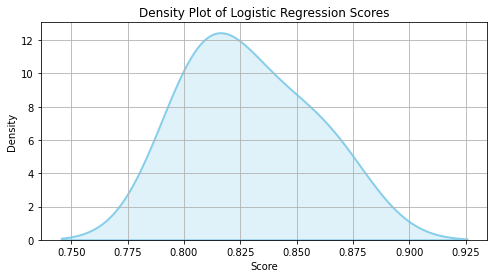

In [256]:
plt.figure(figsize=(8, 4))
sns.kdeplot(scores, fill=True, color='skyblue', linewidth=2)
plt.title("Density Plot of Logistic Regression Scores")
plt.xlabel("Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()


In [261]:
params = lg_results_Array[2]

# Extract C and solver from params
df = pd.DataFrame(params)
df['score'] = scores
df['description'] = updates

df

,C,penalty,solver,score,description
0,1.0,l2,lbfgs,0.806878,1st try
1,0.2,l2,lbfgs,0.808766,Solver is newton-cg/lbfgs and C~1
2,0.2,l2,lbfgs,0.835163,C~5
3,0.2,l2,lbfgs,0.864286,Best GridSearch Params
